In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter 
from sklearn import metrics
import time

Objetivo: Clasificar y comparar las relaciones que se pueden encontrar al analizar países en base a su PIB y la productividad de empleados (horas al dia por cada año) en el trabajo. 

EDA

In [30]:
horas_pib=pd.read_csv('hours-vs-gdp.csv')
horas_pib.describe()

,Year,Annual working hours per worker,"GDP per capita (output, multiple price benchmarks)",Population (historical estimates)
count,56398.000000,3457.000000,10108.000000,5.635000e+04
mean,1839.783911,1983.915922,13121.751931,5.064207e+07
std,300.874339,281.921386,17131.658623,2.973131e+08
min,0.000000,1380.607700,246.741710,0.000000e+00
25%,1839.000000,1787.337800,2617.814225,1.827120e+05
50%,1905.000000,1970.192700,6723.897300,1.524228e+06
75%,1967.000000,2167.461400,16650.070000,7.078786e+06
max,2021.000000,3039.794000,169200.270000,7.909295e+09


In [31]:
horas_pib=horas_pib.dropna()
horas_pib.head()

,Entity,Code,Year,Annual working hours per worker,"GDP per capita (output, multiple price benchmarks)",Population (historical estimates),Continent
2292,Argentina,ARG,2015,1703.4685,21197.7870,43257064.0,South America
3221,Australia,AUS,2015,1746.4835,48712.1900,23820240.0,Oceania
3470,Austria,AUT,2015,1605.2805,49618.7030,8642422.0,Europe
4468,Bangladesh,BGD,2015,2418.7507,3714.8008,157830000.0,Asia
5216,Belgium,BEL,2015,1575.4569,42891.3550,11248306.0,Europe


In [32]:
prod_horas=pd.read_csv('productivity-vs-hours.csv')
prod_horas.describe()


,Year,Annual working hours per worker,Productivity: output per hour worked,Population (historical estimates)
count,58300.000000,3457.000000,3457.000000,5.825200e+04
mean,1601.597479,1983.915922,23.913223,4.901082e+07
std,1428.084201,281.921386,18.855221,2.925549e+08
min,-10000.000000,1380.607700,0.767641,0.000000e+00
25%,1832.000000,1787.337800,9.025296,1.460840e+05
50%,1901.000000,1970.192700,19.199963,1.388504e+06
75%,1965.000000,2167.461400,34.656883,6.600998e+06
max,2021.000000,3039.794000,129.025420,7.909295e+09


In [33]:
prod_horas=prod_horas.dropna()
prod_horas.head()

,Entity,Code,Year,Annual working hours per worker,Productivity: output per hour worked,Population (historical estimates),Continent
2173,Argentina,ARG,2015,1703.4685,26.997778,43257064.0,South America
3154,Australia,AUS,2015,1746.4835,56.053726,23820240.0,Oceania
3413,Austria,AUT,2015,1605.2805,62.702095,8642422.0,Europe
4431,Bangladesh,BGD,2015,2418.7507,4.034060,157830000.0,Asia
5225,Belgium,BEL,2015,1575.4569,66.488235,11248306.0,Europe


In [34]:
merged_data = pd.merge(horas_pib, prod_horas, on=['Entity', 'Code', 'Year', 'Annual working hours per worker'])
# Renombrar las columnas
merged_data.rename(columns={
    'Annual working hours per worker': 'Annual hours',
    'GDP per capita (output, multiple price benchmarks)': 'GDP',
    'Productivity: output per hour worked': 'Productivity',
    'Population (historical estimates)_x': 'Population',
    'Continent_x': 'Continent'
}, inplace=True)
# Eliminar columnas redundantes
merged_data.drop(columns=['Population (historical estimates)_y', 'Continent_y'], inplace=True)
data=merged_data
data

,Entity,Code,Year,Annual hours,GDP,Population,Continent,Productivity
0,Argentina,ARG,2015,1703.4685,21197.7870,43257064.0,South America,26.997778
1,Australia,AUS,2015,1746.4835,48712.1900,23820240.0,Oceania,56.053726
2,Austria,AUT,2015,1605.2805,49618.7030,8642422.0,Europe,62.702095
3,Bangladesh,BGD,2015,2418.7507,3714.8008,157830000.0,Asia,4.034060
4,Belgium,BEL,2015,1575.4569,42891.3550,11248306.0,Europe,66.488235
...,...,...,...,...,...,...,...,...
60,Turkey,TUR,2015,1832.0000,25759.2990,79646176.0,Asia,41.479440
61,United Kingdom,GBR,2015,1669.4652,42629.2340,65224368.0,Europe,53.376090
62,United States,USA,2015,1770.0232,58543.5620,324607776.0,North America,70.636710
63,Uruguay,URY,2015,1556.4283,20543.2520,3402820.0,South America,27.477356


In [35]:
unique_years = data['Year'].unique()
unique_years

array([2015], dtype=int64)

Solo trabajareos con un año,lo cual lo vamos a eliminar del dataframe

In [36]:
merged_data.drop(columns=[ 'Year'], inplace=True)

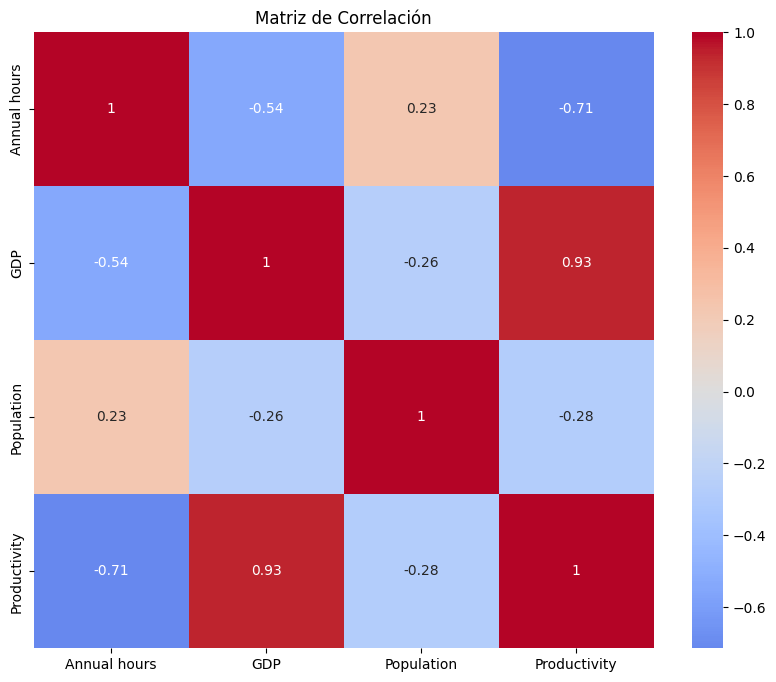

In [37]:
# Seleccionar solo las columnas numéricas
numeric_df = data.select_dtypes(include=[float, int])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

Análisis de la Matriz de Correlación:
GDP y Productividad:
Existe una fuerte correlación positiva entre el PIB (GDP) y la productividad (Productivity) con un valor de correlación cercano a 1. Esto indica que a medida que el PIB aumenta, la productividad también tiende a aumentaro cual es optimo para trabajar con estos datos.


Determinaremos el número óptimo de clústeres utilizando el método del codo, que nos ayudará a identificar el valor adecuado de 𝐾 para ambos algoritmos.

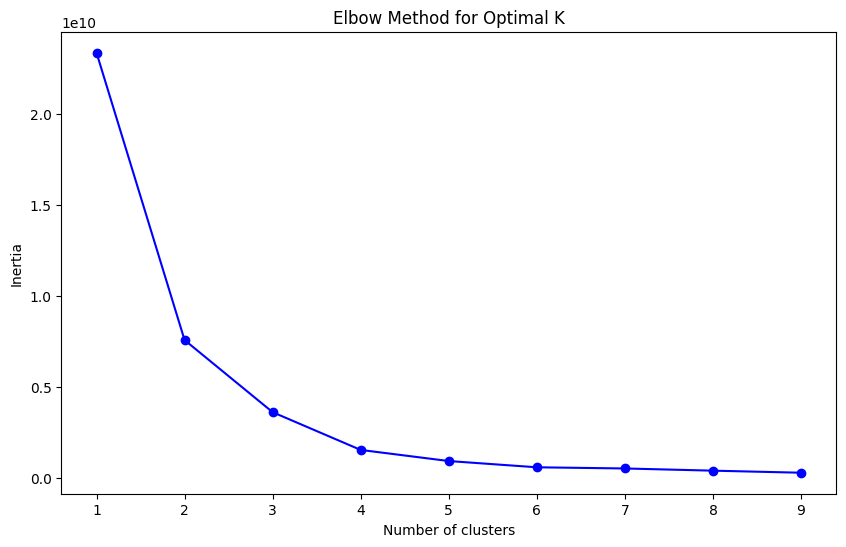

In [38]:
# Seleccionar las características relevantes
X = data[['GDP', 'Productivity']]

# Determinar el número óptimo de clústeres usando el método del codo
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

El codo del gráfico sugiere que el número óptimo de clústeres está alrededor de K=4.

Aplicaremos técnicas de clustering para agrupar territorios basados en dos características económicas: 
Producto Interno Bruto (PIB) y Productividad. Utilizaremos dos algoritmos de clustering populares: KMeans y MiniBatchKMeans. 
La finalidad es comparar el rendimiento y la calidad de los clústeres generados por cada método.

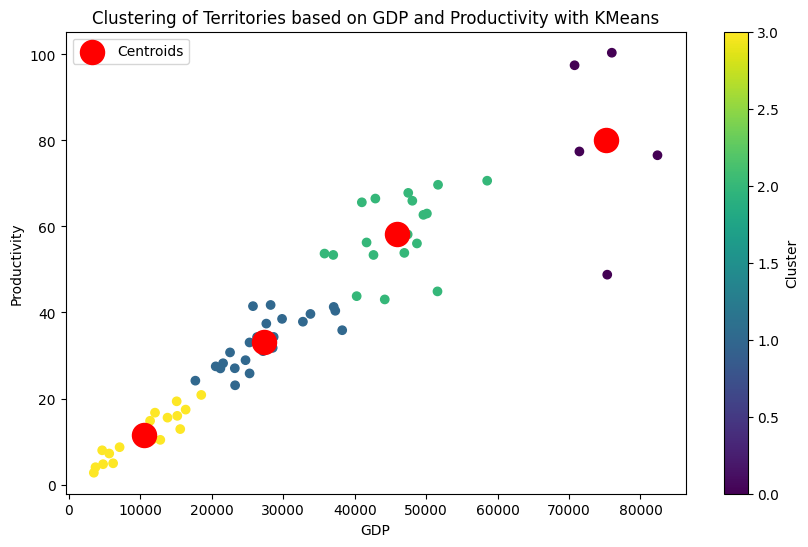

Inertia of KMeans: 13.10


In [39]:
# Seleccionar las características relevantes
X = data[['GDP', 'Productivity']]

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means con el número óptimo de clústeres (por ejemplo, K = 4)
optimal_k = 4  # Supongamos que 4 es el óptimo según el método del codo
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
data['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# Obtener los centroides y calcular la inercia
centroids_kmeans = scaler.inverse_transform(kmeans.cluster_centers_)
inertia_kmeans = kmeans.inertia_

# Visualizar los clústeres y los centroides de KMeans
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['GDP'], data['Productivity'], c=data['Cluster_KMeans'], cmap='viridis')
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('GDP')
plt.ylabel('Productivity')
plt.title('Clustering of Territories based on GDP and Productivity with KMeans')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

print(f'Inertia of KMeans: {inertia_kmeans:.2f}')

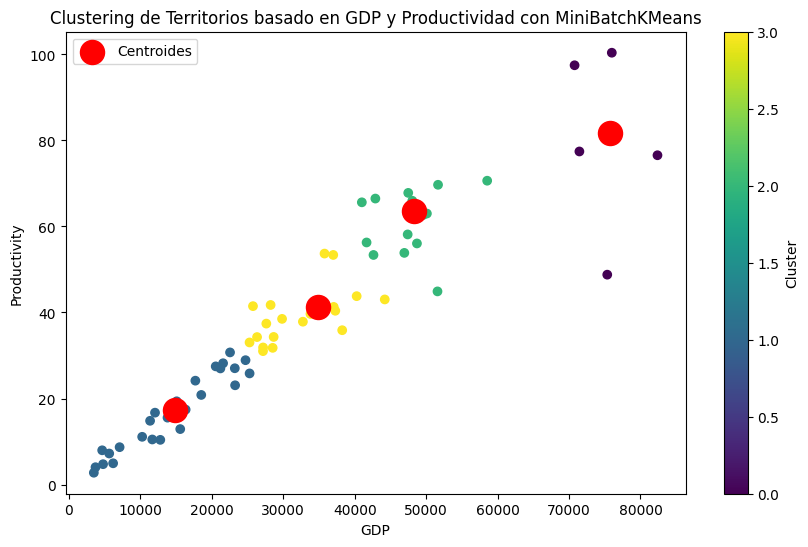

Inertia of MiniBatchKMeans: 16.93


In [40]:
# Aplicar MiniBatchKMeans con el número óptimo de clústeres (por ejemplo, K = 4)
mbkmeans = MiniBatchKMeans(n_clusters=optimal_k, init='k-means++', random_state=0)
data['Cluster_MiniBatchKMeans'] = mbkmeans.fit_predict(X_scaled)

# Obtener los centroides y calcular la inercia
centroids_mbkmeans = scaler.inverse_transform(mbkmeans.cluster_centers_)
inertia_mbkmeans = mbkmeans.inertia_

# Visualizar los clústeres y los centroides de MiniBatchKMeans
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['GDP'], data['Productivity'], c=data['Cluster_MiniBatchKMeans'], cmap='viridis')
plt.scatter(centroids_mbkmeans[:, 0], centroids_mbkmeans[:, 1], s=300, c='red', label='Centroides')
plt.xlabel('GDP')
plt.ylabel('Productivity')
plt.title('Clustering de Territorios basado en GDP y Productividad con MiniBatchKMeans')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

print(f'Inertia of MiniBatchKMeans: {inertia_mbkmeans:.2f}')

Comparación de Inercia:

KMeans:
    Inercia: 13.10
     Una menor inercia indica que los puntos de datos están más cerca de sus respectivos centroides, sugiriendo que los clústeres son más compactos y bien definidos.

MiniBatchKMeans:
    Inercia: 16.93
    Interpretación: Una inercia más alta en comparación con KMeans sugiere que los puntos de datos están más dispersos alrededor de sus centroides. Esto puede indicar clústeres menos compactos y bien definidos que los generados por KMeans.


Inercia:
KMeans: Inercia = 13.10
Produce clústeres más compactos y bien definidos.
MiniBatchKMeans: Inercia = 16.93
Produce clústeres más dispersos, lo que indica que los puntos están menos agrupados alrededor de los centroides.
Visualización:
KMeans:
Clústeres más compactos y claramente definidos.
Mejor separación entre clústeres.
MiniBatchKMeans:
Clústeres más dispersos.
Menos separación entre clústeres en comparación con KMeans.

Estimated number of clusters: 3
Estimated number of noise points: 3
Silhouette Coefficient: 0.496


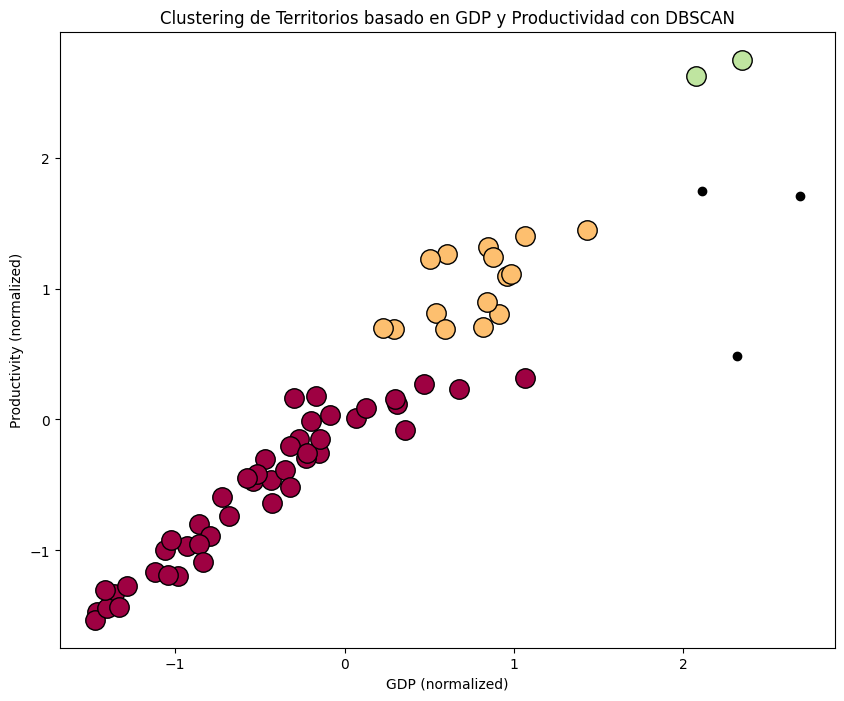

In [41]:
# Seleccionar las características relevantes
X = data[['GDP', 'Productivity']]

# Estandarizar los datos
X = StandardScaler().fit_transform(X)

# Aplicar DBSCAN
db = DBSCAN(eps=0.4, min_samples=2).fit(X)
labels = db.labels_

# Número de clústeres en las etiquetas, ignorando el ruido si está presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Evaluación de los resultados del clustering
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

# Visualización de los resultados del clustering
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(10, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Color para el ruido
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title('Clustering de Territorios basado en GDP y Productividad con DBSCAN')
plt.xlabel('GDP (normalized)')
plt.ylabel('Productivity (normalized)')
plt.show()

Interpretación de los Resultados:

Número de Clústeres y Puntos de Ruido:

Clústeres: DBSCAN identificó 3 clústeres distintos en los datos, lo que indica que hay tres agrupaciones naturales de territorios basadas en el PIB y la productividad.
Puntos de Ruido: Hay 3 puntos considerados como ruido (etiquetados como -1). Estos puntos no se agrupan con ninguno de los clústeres principales y pueden considerarse como outliers o datos anómalos.
Coeficiente de Silueta:

Valor del Coeficiente de Silueta (0.496):
Este valor está en un rango moderado, sugiriendo que los clústeres tienen una definición razonablemente buena. Un valor cercano a 1 indica que los puntos están bien agrupados, mientras que un valor cercano a -1 indica que los puntos están mal agrupados.
En este caso, un valor de 0.496 indica que los clústeres formados son bastante compactos y bien separados, pero podría haber margen para mejorar la separación.


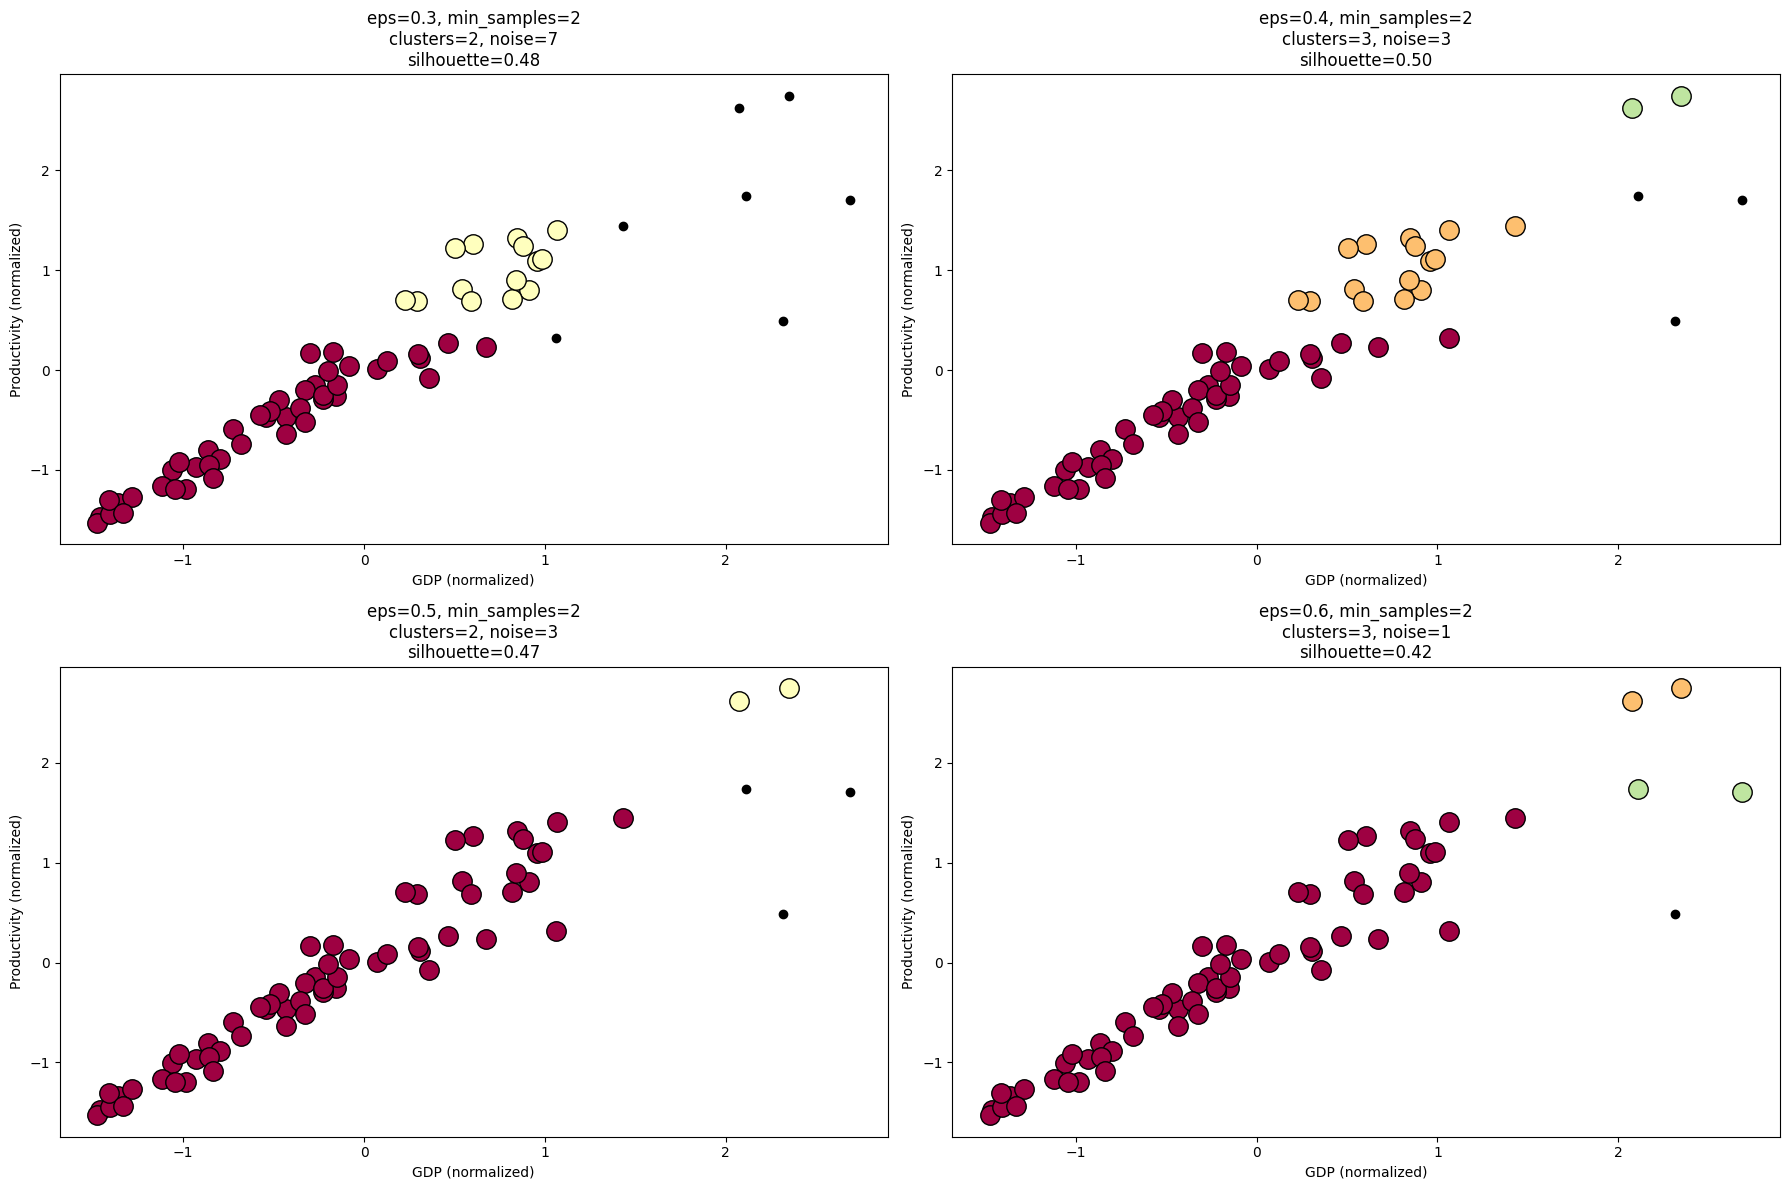

In [42]:

X = data[['GDP', 'Productivity']]

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir los hiperparámetros a probar
eps_values = [0.3, 0.4, 0.5, 0.6]
min_samples = 2

# Crear una figura para las visualizaciones
plt.figure(figsize=(18, 12))

for i, eps in enumerate(eps_values):
    # Aplicar DBSCAN con los hiperparámetros actuales
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
    labels = db.labels_

    # Número de clústeres en las etiquetas, ignorando el ruido si está presente.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Evaluación de los resultados del clustering
    silhouette_coefficient = metrics.silhouette_score(X_scaled, labels) if n_clusters_ > 1 else -1

    # Visualización de los resultados del clustering
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    ax = plt.subplot(2, 2, i+1)  # Crear un subplot de 2 filas y 2 columnas
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Color para el ruido
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_scaled[class_member_mask]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            'o',
            markerfacecolor=tuple(col),
            markeredgecolor='k',
            markersize=14 if k != -1 else 6,
        )

    ax.set_title(f'eps={eps}, min_samples={min_samples}\nclusters={n_clusters_}, noise={n_noise_}\nsilhouette={silhouette_coefficient:.2f}')
    ax.set_xlabel('GDP (normalized)')
    ax.set_ylabel('Productivity (normalized)')

plt.tight_layout()
plt.show()

Mejor Valor de ϵ:
Según los resultados obtenidos, un valor de ϵ=0.4 proporciona el mejor balance entre la cantidad de clústeres formados y el coeficiente de silueta.
Este valor permite identificar clústeres bien definidos con una cantidad mínima de puntos de ruido, como se observa en la gráfica correspondiente.
Impacto deϵ:

Valores más bajos de 𝜖 (por ejemplo, 0.3) tienden a producir más ruido y menos clústeres.
Valores más altos deϵ (por ejemplo, 0.6) tienden a agrupar más puntos, reduciendo el ruido, pero también disminuyen la calidad de los clústeres, lo cual se refleja en un menor coeficiente de silueta.